In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append("..")

import jax
import jax.numpy as jnp
from jax import vmap, jit

import time
import matplotlib.pyplot as plt

In [2]:
from evosax.strategies.cma_es import init_strategy, ask, tell, check_termination
from evosax.utils import init_logger, update_logger
from evosax.utils import flat_to_network, get_total_params, get_network_shapes

from evosax.problems.pendulum import reset, step, env_params
from examples.ffw_pendulum import pendulum_rollout, init_policy_mlp

In [3]:
rng = jax.random.PRNGKey(0)

# Episode Rollout from Randomly Init Policy

In [4]:
# Rollout single episode with lax.scan
rng, rng_input = jax.random.split(rng)
policy_params = init_policy_mlp(rng_input, [3, 16, 1], scale=1e-2)

rng, rng_input = jax.random.split(rng)
pendulum_rollout(rng_input, policy_params, env_params)

DeviceArray(-600.16327, dtype=float32)

In [5]:
total_no_params = get_total_params(policy_params)
network_shapes = get_network_shapes(policy_params)
print(total_no_params, network_shapes)

81 FrozenDict({
    layer_in: {
        W1: (16, 3),
        b1: (16,),
    },
    layer_out: {
        W2: (1, 16),
        b2: (1,),
    },
})


## Vectorized Parallel Rollout of Eps with vmap

In [6]:
# Rollout a batch of parallel episodes using vmap
batch_rollout = jit(vmap(pendulum_rollout, in_axes=(0, None, None),
                         out_axes=0), static_argnums=(2))
rng, rng_input = jax.random.split(rng)
rollout_keys = jax.random.split(rng_input, 10)
batch_rollout(rollout_keys, policy_params, env_params)

DeviceArray([ -626.7644 , -1068.5372 , -1775.2993 , -1148.9524 ,
              -863.488  ,  -710.9215 ,  -940.70044, -1348.843  ,
             -1785.6412 , -1167.9044 ], dtype=float32)

In [7]:
# Wrap reshaping of param vector and rollout into single fct. to vmap
def reshape_and_eval(rng, x, network_shapes, env_params):
    """ Perform both parameter reshaping and evaluation in one go. """
    net_params = flat_to_network(x, network_shapes)
    returns = batch_rollout(rng, net_params, env_params)
    return - returns.mean()

In [8]:
# Generate a batch of 2 weight initialisations
generation_params = jnp.zeros((2, total_no_params))

In [9]:
# Rollout 10 episodes for 5 agents in parallel
generation_rollout = vmap(reshape_and_eval, in_axes=(None, 0, None, None))
results = generation_rollout(rollout_keys, generation_params, network_shapes, env_params)
print(results)

[1147.4299 1147.4299]


# Neuroevolution with CMA-ES

In [10]:
rng = jax.random.PRNGKey(1234)
mean_init, sigma_init = jnp.zeros(total_no_params), 1
pop_size, mu = 100, 50
num_evals_per_gen = 20
num_generations = 200

top_k = 5
evo_logger = init_logger(top_k, total_no_params)

params, memory = init_strategy(mean_init, sigma_init,
                               pop_size, mu)

# Run generation loop on Pendulum Task

In [11]:
start_t = time.time()
for g in range(num_generations):
    # Ask ES for next generation params
    rng, rng_ask, rng_eval = jax.random.split(rng, 3)
    x, memory = ask(rng_input, params, memory)
    
    # Reshape and rollout/eval batch
    rollout_keys = jax.random.split(rng_eval, num_evals_per_gen)
    values = generation_rollout(rollout_keys, x,
                                network_shapes, env_params)

    # Update ES, log + check for termination
    memory = tell(x, values, params, memory)
    evo_logger = update_logger(evo_logger, x, values, memory, top_k)
    if (g + 1) % 15 == 0:
        print("# Generations: {} | Fitness: {:.2f} | Cum. Time: {:.2f}".format(
                g+1, evo_logger["top_values"][0],
                time.time()-start_t))
        # jnp.save("gen_" + str(g+1), evo_logger["top_params"])
        if check_termination(values, params, memory):
            break

# Generations: 15 | Fitness: 823.66 | Cum. Time: 6.37
# Generations: 30 | Fitness: 244.95 | Cum. Time: 7.70
# Generations: 45 | Fitness: 167.91 | Cum. Time: 8.75
# Generations: 60 | Fitness: 146.75 | Cum. Time: 9.81
# Generations: 75 | Fitness: 138.37 | Cum. Time: 10.74
# Generations: 90 | Fitness: 111.20 | Cum. Time: 11.67
# Generations: 105 | Fitness: 111.20 | Cum. Time: 12.55
# Generations: 120 | Fitness: 111.20 | Cum. Time: 13.49
# Generations: 135 | Fitness: 111.20 | Cum. Time: 14.43
# Generations: 150 | Fitness: 111.20 | Cum. Time: 15.37
# Generations: 165 | Fitness: 111.20 | Cum. Time: 16.22
# Generations: 180 | Fitness: 111.20 | Cum. Time: 17.14
# Generations: 195 | Fitness: 111.20 | Cum. Time: 18.04


# Visualize log over generations

In [12]:
from evosax.visualize.plot_log import plot_fitness, plot_sigma
import matplotlib.pyplot as plt

(<Figure size 864x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa647dd8470>)

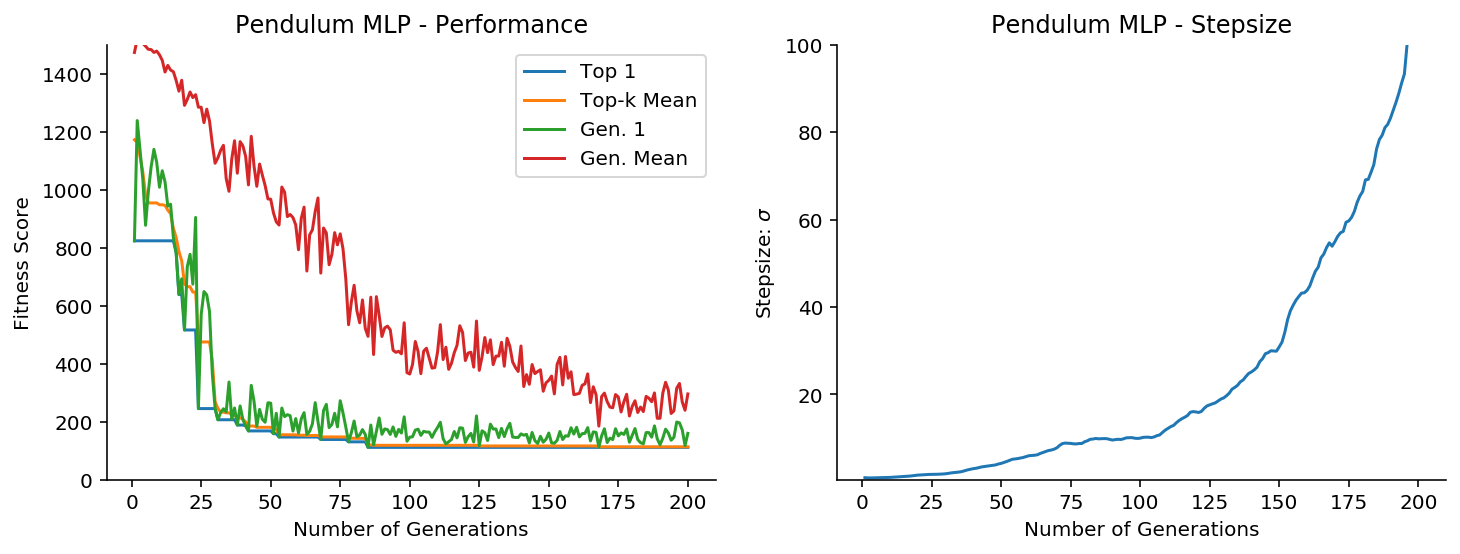

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_fitness(evo_logger, title="Pendulum MLP - Performance", ylims=(0, 1500), fig=fig, ax=axs[0])
plot_sigma(evo_logger, title="Pendulum MLP - Stepsize", ylims=(0.5, 100), fig=fig, ax=axs[1])